In [1]:
import numpy as np
%pylab inline
%load_ext autoreload
%autoreload 2
%precision 3

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


'%.3f'

In [2]:
from sklearn.metrics.pairwise import pairwise_kernels
from itertools import chain, product
from sklearn.datasets import make_blobs
from scipy.optimize import check_grad, approx_fprime, minimize
import scipy as sp
import itertools

### Preparing some data to test

In [101]:
## making some data
np.random.seed(4)
n, d = 300, 3
mk, K = 4, 2
X, y = make_blobs(n, d)
EPS = 1e-6

In [102]:
y

array([1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0,
       1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0,
       0, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 2, 2, 1,
       1, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 2,
       1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 2, 0, 2,
       2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 1,
       1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2,
       1, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0,
       0, 0, 2, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2,
       0, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 2, 2,
       0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 1,
       0, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2,
       2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 0])

In [103]:
## randomly initialize initial solutions for optimisation
def choose_A0(X, y, m, K):
    idxs = []
    for k in range(K):
        idxs.append(np.random.choice(np.where(y == k)[0], m // K, replace = False))
    A0 = X[np.concatenate(idxs)]
    A0 = A0 + np.random.normal(size = A0.shape)
    return A0

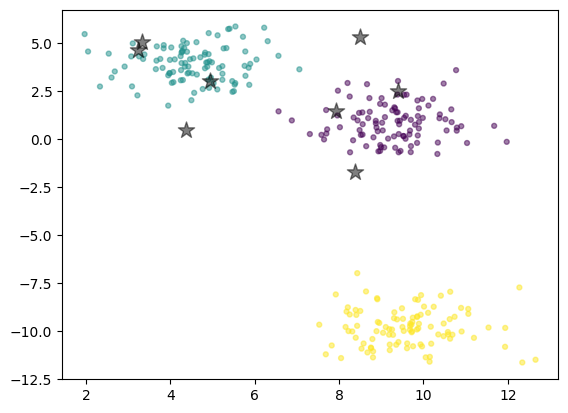

In [104]:
m = mk * K
A0 = choose_A0(X, y, m, K)
plt.scatter(X[:, 0], X[:, 1], c = y, marker = ".", alpha = 0.5, s = 50)
plt.scatter(A0[:, 0], A0[:, 1], c = "k", marker = "*", alpha = 0.5, s = 150)

In [52]:
import subm
import contra_sum_utils as utils

In [57]:
y.shape

(300,)

In [56]:
X.shape

(300, 2)

In [24]:
K_mat = utils.Kernel.create(X, metric = 'rbf', gamma = 0.5)
sol_greedy = subm.greedy_maximize_labels(subm.MMD(), - 1.0 * subm.MMD(), 
                                         V = np.arange(len(X)), y = y, k = 4, lambdaa=0.1,
                                         delF_args = {"K": K_mat}, delG_args = {"K": K_mat})
protos = itertools.chain(*sol_greedy.values())

*

In [25]:
K_mat

[0.0000, 0.0000, 1.000000]

In [9]:
sol_greedy

{0: [], 1: [290, 136, 114, 246], 2: [252, 109, 279, 98]}

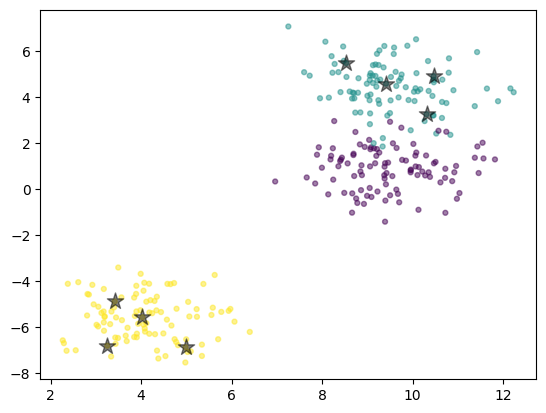

In [10]:
protos = list(protos)
plt.scatter(X[:, 0], X[:, 1], c = y, marker = ".", alpha = 0.5, s = 50)
plt.scatter(X[protos, :][:, 0], X[protos, :][:, 1], c = "k", marker = "*", alpha = 0.5, s = 150)

### Try on a real example:

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer()

In [112]:
corpus = [ 
        # ("the content is informative and relevant.", 0),
        # ("the content is clear and informative.", 0),
        # ("the content is detailed and informative.", 0),
        # ("the tone is conversational and informal.", 0),
    
        ("the writer uses casual language in their writing.", 1),
        ("the content is informative and relevant.", 1),
        ("the writer uses clear language.", 1),
        ("the writer uses technical language in their writing.", 1),
        ("the writer uses technical language.", 1),

        ("the writer uses casual language in their writing.", 2),
        ("the writer uses clear language.", 2),
        ("the writer uses technical language in their writing.", 2),
        ("the writer uses technical language.", 2)
]


X = vectorizer.fit_transform([s[0] for s in corpus]).toarray()
y = np.array([s[1] for s in corpus])

In [113]:
K_mat = utils.Kernel.create(X, metric = 'cosine')

In [114]:
X.shape

(9, 15)

In [115]:
y.shape

(9,)

In [119]:
sol_greedy = subm.greedy_maximize_labels(subm.MMD(), - 1.0 * subm.MMD(), 
                                         V = np.arange(len(X)), y = y, k = 2, lambdaa=0.9,
                                         delF_args = {"K": K_mat}, delG_args = {"K": K_mat})

c_rep = {x[0]:[corpus[y] for y in x[1]] for x in sol_greedy.items()}
c_rep

*

{1: [('the content is informative and relevant.', 1),
  ('the writer uses clear language.', 1)],
 2: [('the writer uses technical language in their writing.', 2),
  ('the writer uses technical language.', 2)]}

In [120]:
sol_greedy = subm.greedy_maximize_labels(subm.MMD(), - 1.0 * subm.MMD(), 
                                         V = np.arange(len(X)), y = y, k = 2, lambdaa=0.1,
                                         delF_args = {"K": K_mat}, delG_args = {"K": K_mat})

c_rep = {x[0]:[corpus[y] for y in x[1]] for x in sol_greedy.items()}
c_rep

*

{1: [('the writer uses technical language in their writing.', 1),
  ('the writer uses clear language.', 1)],
 2: [('the writer uses technical language in their writing.', 2),
  ('the writer uses clear language.', 2)]}